In [2]:
import math
import pickle
import time
from functools import reduce
from pandarallel import pandarallel

import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots

from utils.my_cache import cache_wrapper
from utils.functions import *
from scipy.stats import zscore

from csmarapi.ReportUtil import ReportUtil


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
csmar = CsmarService()
pandarallel.initialize()

csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Tue 25 Oct 2022 08:54:59 CsmarService.py INFO User login succeed


## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

- SVC related: `previous research`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic; stock fund adjusted net asset value (2005/6-2019/6)

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

## **II. Market Statistic**

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.Wind.wind_validate_share_nav import *
from data.AMAC.amac_full_market_value import amac_full_market_value
from utils.my_cache import cache_wrapper
from utils.functions import *

split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| all | all fund share | all fund nav |
| blend | blend fund share | blend fund nav |

In [226]:
wind_validate_share = wind_validate_share_nav.loc['基金份额', slice(None)]
wind_validate_share.columns = wind_validate_share.columns.str.split('.').str[0]
wind_validate_share = wind_validate_share[ ~ wind_validate_share.index.duplicated(keep='last')]

In [227]:
wind_validate_nav = wind_validate_share_nav.loc['单位净值', slice(None)]
wind_validate_nav.columns = wind_validate_nav.columns.str.split('.').str[0]
wind_validate_nav = wind_validate_nav[ ~ wind_validate_nav.index.duplicated(keep='last')]

In [228]:
wind_stock_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [229]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_num = pd.notna(wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_num.index = wind_blend_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_mkt_value = (wind_blend_fund_share * wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_mkt_value.index  = wind_blend_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

align JoinQuant && CSMAR data

In [230]:
csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')


In [231]:
selected_month = 6

csmar_share_info_6 = csmar_share_info[csmar_share_info.index.month == selected_month]
csmar_nav_monthly_6 = csmar_nav_monthly[csmar_nav_monthly.index.month == selected_month]

csmar_blend_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_6.columns)

csmar_co_time_6 = np.intersect1d(csmar_share_info_6.index, csmar_nav_monthly_6.index)




In [232]:
csmar_blend_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_blend_mkt_value_jq_classify.index = csmar_blend_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

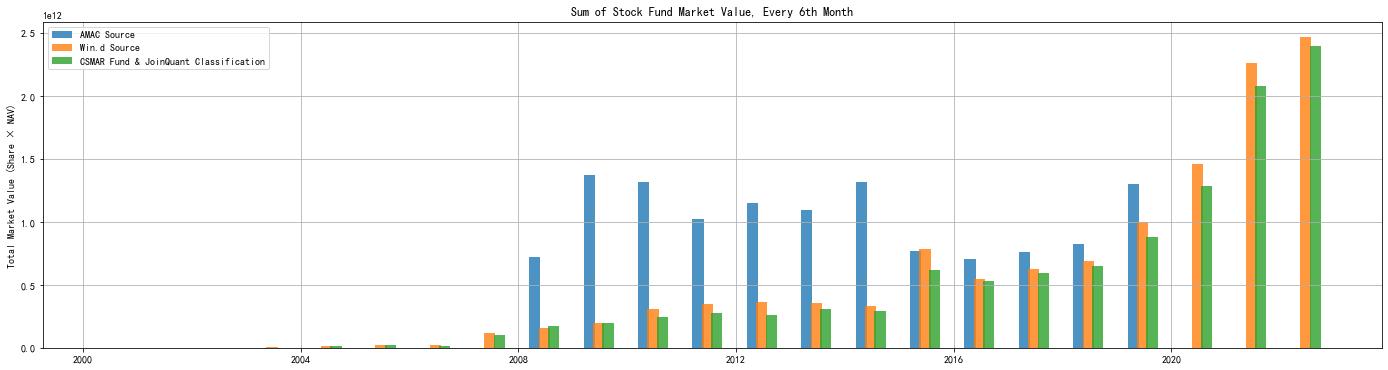

In [233]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.股票基金.index - pd.Timedelta('10W'), amac_full_market_value.股票基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund Market Value, Every 6th Month')
plt.legend()
plt.show()

blend funds market value

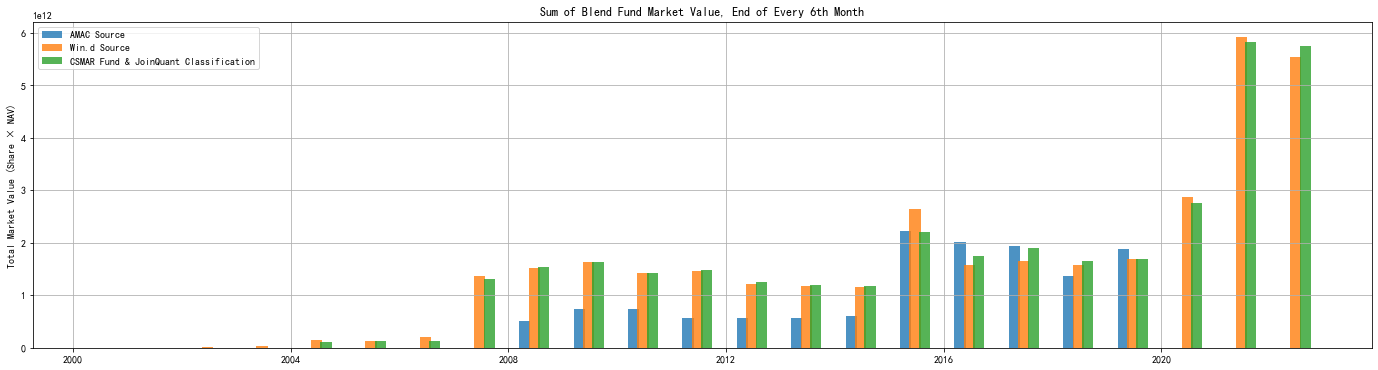

In [234]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), amac_full_market_value.混合基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), wind_blend_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_blend_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Blend Fund Market Value, End of Every 6th Month')
plt.legend()
plt.show()

(stock + blend) funds market value

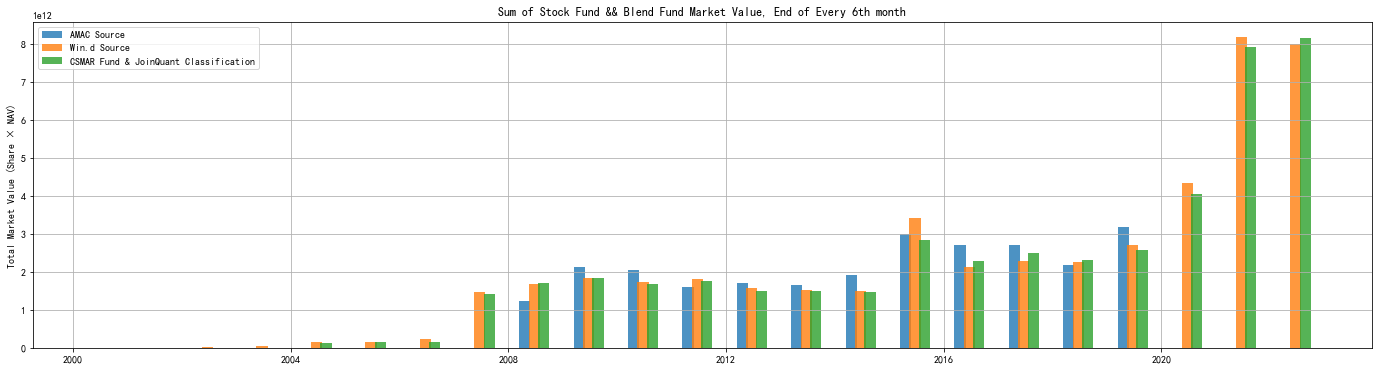

In [235]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), (amac_full_market_value.混合基金.values + amac_full_market_value.股票基金.values) * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_blend_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_blend_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund && Blend Fund Market Value, End of Every 6th month')
plt.legend()
plt.show()

fund counts

In [236]:
csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

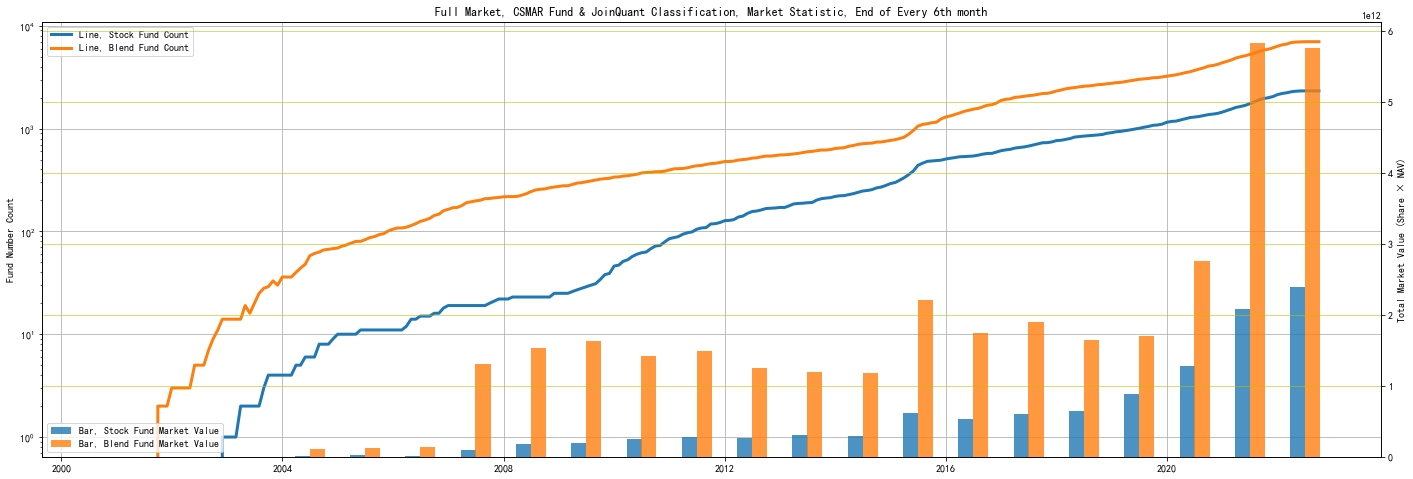

In [237]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

csmar_nav_monthly_6.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


ax1.plot(csmar_stock_fund_count, linewidth=3, label='Line, Stock Fund Count')
ax1.plot(csmar_blend_fund_count, linewidth=3, label='Line, Blend Fund Count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()
ax1.set_ylabel('Fund Number Count')

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='Bar, Stock Fund Market Value', alpha=.8)

plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_blend_mkt_value_jq_classify.values, width=100, label='Bar, Blend Fund Market Value', alpha=.8)

plt.title('Full Market, CSMAR Fund & JoinQuant Classification, Market Statistic, End of Every 6th month')

ax2.grid(color='y', alpha=.7)
plt.ylabel('Total Market Value (Share × NAV)')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.show()


## **III. Filters**

In [14]:
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.FUND_MainInfo import csmar_maininfo
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

### preview

In [5]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(csmar_nav_daily.Symbol.unique().astype(str), 6), jq_all_fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(jq_all_fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'operate_mode', 'underlying_asset_type', 'start_date']]


In [6]:
specs = [[{'type':'domain'}] * 2]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['JoinQuant Asset Type', 'JoinQuant Operation Mode'])
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金非 ETF 类基金、非 QDII 类基金

<!-- （4）主动管理标识为 1 或者为空； -->

In [7]:
final_main_info

,main_code,operate_mode,underlying_asset_type,start_date
0,000001,开放式基金,混合型,2001-12
1,000003,开放式基金,债券型,2013-03
2,000004,开放式基金,债券型,2013-03
3,000005,开放式基金,债券型,2013-03
4,000006,开放式基金,混合型,2019-03
...,...,...,...,...
16395,968083,开放式基金,债券型,2020-04
16396,968084,开放式基金,债券型,2020-04
16397,968085,开放式基金,债券型,2020-04
16398,968086,开放式基金,债券型,2020-04


In [8]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = np.logical_and(final_main_info.operate_mode != 'ETF', final_main_info.operate_mode != 'QDII')

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.61981707, 0.93195122])

In [9]:

def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16400 to 10165
filter 2: 10165 to 9254


In [10]:
final_main_info = final_main_info[filters_]
final_main_info.set_index('main_code').sort_index()

,operate_mode,underlying_asset_type,start_date
main_code,,,
000001,开放式基金,混合型,2001-12
000006,开放式基金,混合型,2019-03
000011,开放式基金,混合型,2004-08
000017,开放式基金,混合型,2013-03
000020,开放式基金,混合型,2013-03
...,...,...,...
968045,开放式基金,股票型,2019-03
968046,开放式基金,股票型,2019-03
968047,开放式基金,股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [11]:
indexes = pd.MultiIndex.from_product([final_main_info.main_code.sort_values().values, pd.date_range('2000-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[csmar_nav_monthly[final_main_info.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2001-12        开放式基金                   混合型    2001-12
       2002-01        开放式基金                   混合型    2001-12
       2002-02        开放式基金                   混合型    2001-12
       2002-03        开放式基金                   混合型    2001-12
       2002-04        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
968049 2022-05        开放式基金                   股票型    2019-03
       2022-06        开放式基金                   股票型    2019-03
       2022-07        开放式基金                   股票型    2019-03
       2022-08        开放式基金                   股票型    2019-03
       2022-09        开放式基金                   股票型    2019-03

[418180 rows x 3 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [12]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info)} to {record_shape}'

'in view of 2022, filter 3: 9254 to 7150'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

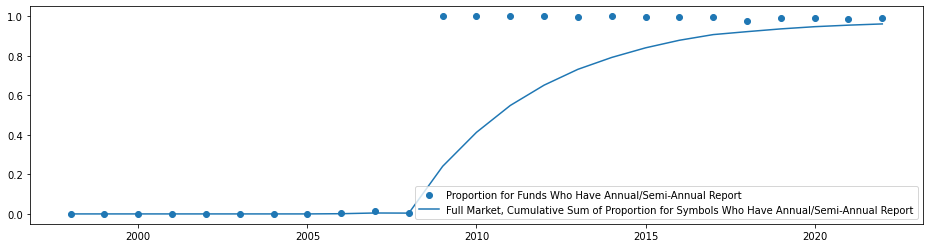

In [15]:
csmar_fund_allocation['report_type_check'] = csmar_fund_allocation.Date.dt.year
report_type_check = csmar_fund_allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='Proportion for Funds Who Have Annual/Semi-Annual Report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='Full Market, Cumulative Sum of Proportion for Symbols Who Have Annual/Semi-Annual Report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [16]:
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.ReportTypeID.isin([2, 5, 6])]
csmar_fund_allocation = pd.merge(csmar_fund_allocation, csmar_symbol_code_mapping, on='MasterFundCode', how='left')
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[csmar_fund_allocation.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [17]:
filter_4 = csmar_fund_allocation[(csmar_fund_allocation.Equity / csmar_fund_allocation.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2003-06        开放式基金                   混合型    2001-12
       2003-07        开放式基金                   混合型    2001-12
       2003-08        开放式基金                   混合型    2001-12
       2003-09        开放式基金                   混合型    2001-12
       2003-10        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
952009 2022-05        封闭式基金                   混合型    2020-01
       2022-06        封闭式基金                   混合型    2020-01
       2022-07        封闭式基金                   混合型    2020-01
       2022-08        封闭式基金                   混合型    2020-01
       2022-09        封闭式基金                   混合型    2020-01

[235754 rows x 3 columns]

In [18]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 7150 to 5286'

### 4. full data

reset nav

In [19]:
csmar_nav_monthly = pd.Series(csmar_nav_monthly.stack().swaplevel(), name='NAV')
csmar_nav_monthly = pd.DataFrame(csmar_nav_monthly).reset_index()

merge data

In [20]:
main_data = pd.merge(main_data, csmar_nav_monthly, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [21]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

combine csmar category

In [22]:
csmar_category_symbol_mapping = pd.merge(csmar_maininfo[['MasterFundCode', 'Category']].drop_duplicates(), \
    csmar_symbol_code_mapping, on='MasterFundCode', how='left')[['Category', 'Symbol']]
csmar_category_symbol_mapping = csmar_category_symbol_mapping.drop_duplicates().reset_index(drop=True)
csmar_category_symbol_mapping = csmar_category_symbol_mapping.groupby('Symbol').last()

main_data = pd.merge(main_data.reset_index(), csmar_category_symbol_mapping, on='Symbol').set_index(['Symbol', 'Date'])
main_data

operate_mode underlying_asset_type start_date     NAV  \
Symbol Date                                                            
000001 2003-06        开放式基金                   混合型    2001-12  0.9730   
       2003-07        开放式基金                   混合型    2001-12  0.9860   
       2003-08        开放式基金                   混合型    2001-12  0.9540   
       2003-09        开放式基金                   混合型    2001-12  0.9200   
       2003-10        开放式基金                   混合型    2001-12  0.9360   
...                     ...                   ...        ...     ...   
952009 2022-05        封闭式基金                   混合型    2020-01  1.7120   
       2022-06        封闭式基金                   混合型    2020-01  1.8868   
       2022-07        封闭式基金                   混合型    2020-01  1.7885   
       2022-08        封闭式基金                   混合型    2020-01  1.7257   
       2022-09        封闭式基金                   混合型    2020-01  1.7006   

                DividendperShare  SplitRatio Category  
Symbol Date                                            
000001 2003-06             0.033         1.0    混合型基金  
       2003-07             0.000         1.0    混合型基金  
       2003-08             0.000         1.0    混合型基金  
       2003-09             0.000         1.0    混合型基金  
       2003-10             0.000         1.0    混合型基金  
...                          ...         ...      ...  
952009 2022-05             0.000         1.0    混合型基金  
       2022-06             0.000         1.0    混合型基金  
       2022-07             0.000         1.0    混合型基金  
       2022-08             0.000         1.0    混合型基金  
       2022-09             0.000         1.0    混合型基金  

[235650 rows x 7 columns]

## **IV. Overall Performance**

### Return

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

#### 1. prepare

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.TwoStepData.main_data import main_data
from utils.functions import *

NAV_shift calculation

In [88]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

split into stock fund and blend fund

apply formula

In [89]:
blend_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']


return_of_csmar_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_csmar_blend_fund = blend_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_all_fund = main_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)


market value weight generation

In [90]:
MONTH_OF_YEAR = 6

csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

csmar_share_info_yearly = csmar_share_info[csmar_share_info.index.month == MONTH_OF_YEAR]
csmar_nav_yearly = csmar_nav_monthly[csmar_nav_monthly.index.month == MONTH_OF_YEAR]

csmar_co_time_6 = np.intersect1d(csmar_share_info_yearly.index, csmar_nav_yearly.index)

csmar_blend_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_yearly.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_yearly.columns)



csmar_stock_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])

csmar_stock_fund_weight_yearly = pd.concat([csmar_stock_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_stock_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_stock_fund_weight_yearly.columns)])

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.resample('M').ffill()

stock_fund_dates = return_of_csmar_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_csmar_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)
print(f'{stock_fund_new} will not be used')

stock_fund_funds = np.intersect1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.loc[stock_fund_dates, stock_fund_funds]
csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.div(csmar_stock_fund_weight_yearly.sum(axis=1), axis=0)

[] will not be used


In [91]:

csmar_blend_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
csmar_blend_fund_weight_yearly = pd.concat([csmar_blend_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_blend_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_blend_fund_weight_yearly.columns)])
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.resample('M').ffill()

blend_fund_dates = return_of_csmar_blend_fund.unstack(level=0).index
blend_fund_funds = return_of_csmar_blend_fund.unstack(level=0).columns

blend_fund_new = np.setdiff1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)
print(f'{blend_fund_new} will not be used')
blend_fund_funds = np.intersect1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)

csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.loc[blend_fund_dates, blend_fund_funds]
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.div(csmar_blend_fund_weight_yearly.sum(axis=1), axis=0)


['960002' '960004'] will not be used


#### 2. analysis

use data later than 2005-06

In [92]:
return_of_csmar_stock_fund.unstack(level=0)

Symbol,000042,000059,000082,000176,000309,000311,000312,000313,000326,000368,...,660011,671030,673090,673100,673101,690008,700002,740101,960000,960022
Date,,,,,,,,,,,,,,,,,,,,,
2004-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05,1.020766,1.047896,1.052759,1.019350,1.151059,1.006233,1.030889,1.030550,1.111645,1.029243,...,1.069429,1.085950,1.026093,1.015870,1.015432,1.062696,1.037784,1.031538,1.027870,NaN
2022-06,1.083720,1.093872,1.097926,1.108846,1.162114,1.099558,1.119288,1.118925,1.121493,1.075491,...,1.073979,1.186415,1.074244,1.107217,1.106920,1.073746,1.108399,1.108128,1.077097,NaN
2022-07,0.948945,0.927085,0.957503,0.934405,1.009198,0.938431,0.939431,0.939095,0.964950,0.943766,...,0.979501,0.951419,0.950455,0.940773,0.940471,0.967033,0.946249,0.946837,0.934307,NaN


Text(0.5, 1.0, 'Across Funds, Mean of Rolling 12 Months Volatility')

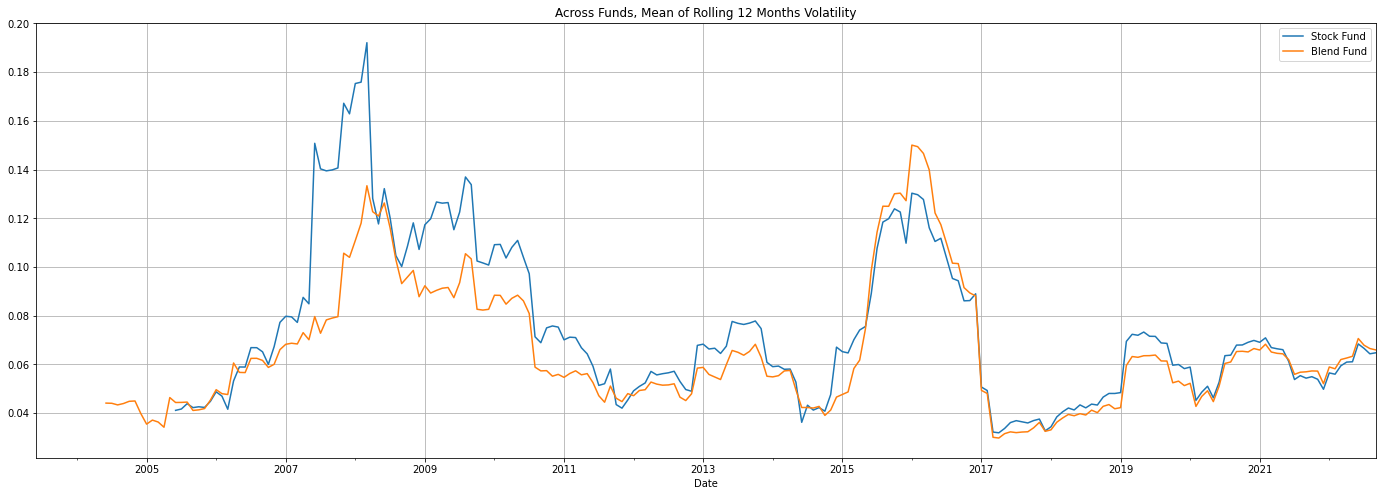

In [93]:
plt.figure(figsize=(24, 8))
rolling_months = 12
(return_of_csmar_stock_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Stock Fund')
(return_of_csmar_blend_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Blend Fund')
plt.grid()
plt.legend()
plt.title(f'Across Funds, Mean of Rolling {rolling_months} Months Volatility')

<AxesSubplot:>

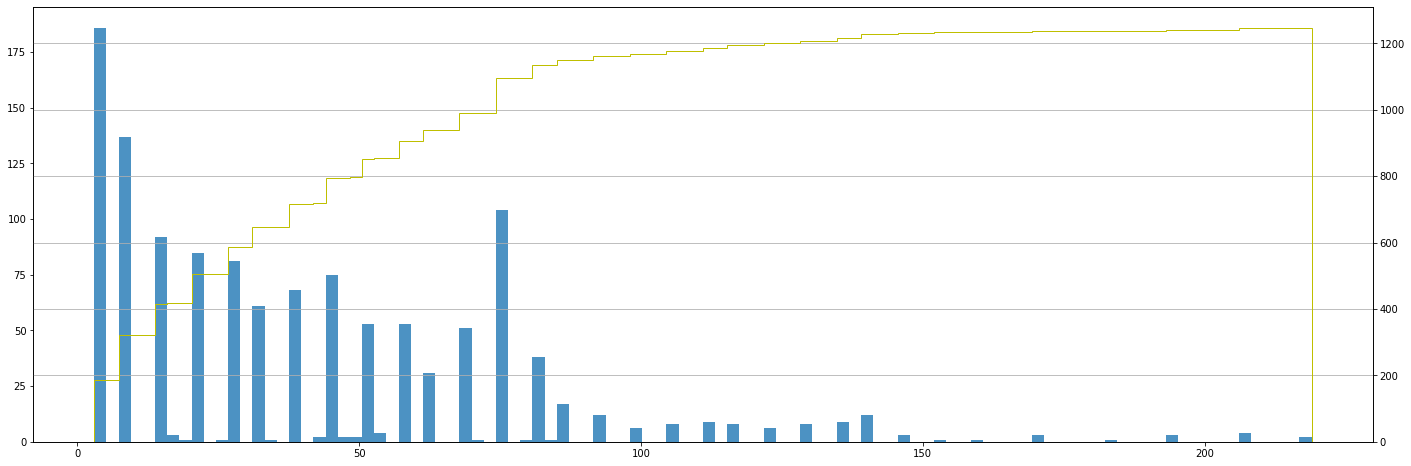

In [94]:
fig, ax = plt.subplots(figsize=(24, 8))
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, ax=ax, alpha=.8)
ax.grid(False)
ax1 = ax.twinx()
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, cumulative=True, histtype='step', ax=ax1, color='y')

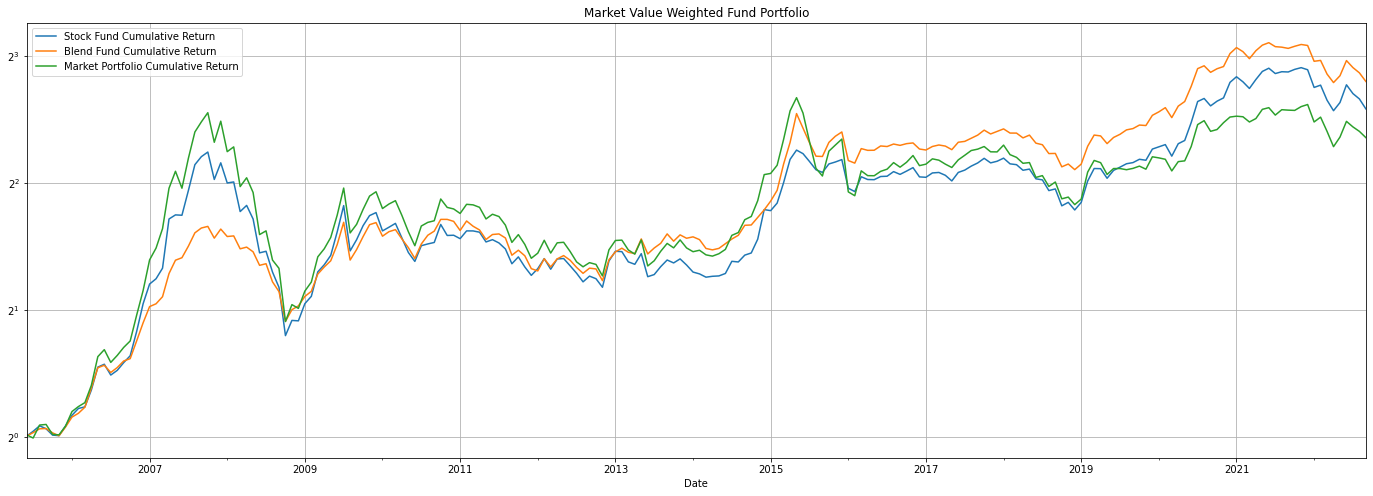

In [95]:
plt.figure(figsize=(24,8))

(((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
(((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc['2005-6': ].mktrf + svc_source.loc['2005-6': ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.yscale('log', base=2)
plt.title('Market Value Weighted Fund Portfolio')
plt.grid()
plt.legend()
plt.show()


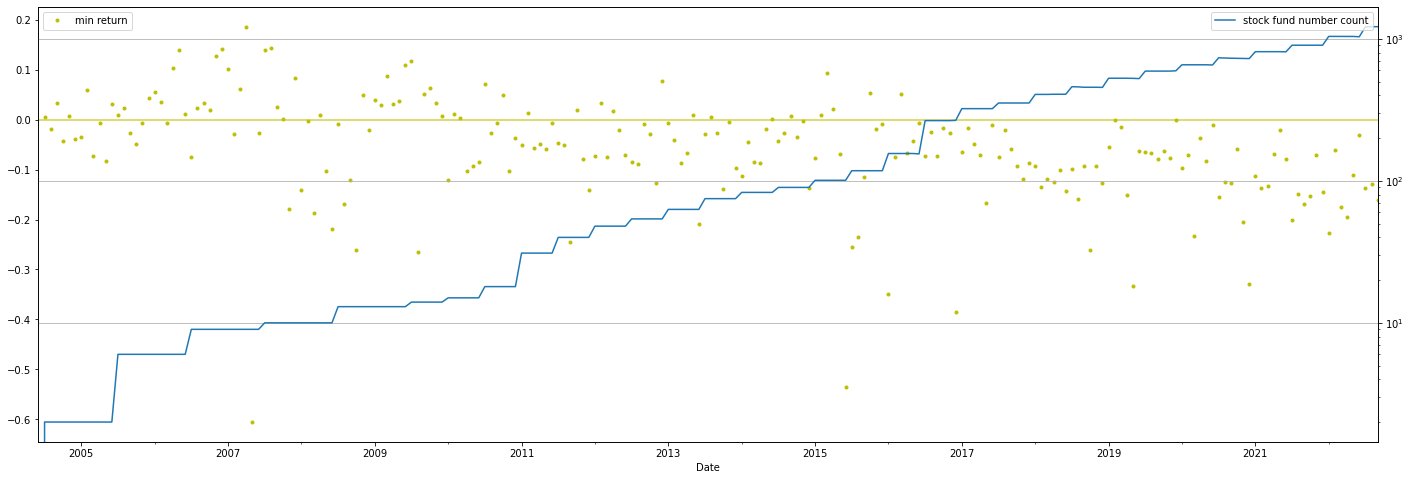

In [96]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['min'].plot(ax=ax1, style='.', label='min return', color='y')
ax1.legend()
ax1.legend(loc='upper left')
ax1.axhline(color='y', alpha=.7)
ax2 = ax1.twinx()
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['count'].plot(ax=ax2, label='stock fund number count')
ax2.grid()
ax2.set_yscale('log')
ax2.legend(loc='upper right')

In [97]:
# plt.figure(figsize=(24,8))
# return_of_stock_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
# return_of_blend_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
# plt.yscale('log', base=2)
# plt.title('1/N Weighted Fund Portfolio')
# plt.grid()
# plt.legend()

why use data later than 2005-06?

In [98]:
co_time = np.intersect1d(csmar_share_info.index, csmar_nav_monthly.index)
co_stocks = np.intersect1d(csmar_share_info.columns, csmar_nav_monthly.columns)
compare_share_info = csmar_share_info.loc[co_time, co_stocks]
compare_nav_monthly = csmar_nav_monthly.loc[co_time, co_stocks]

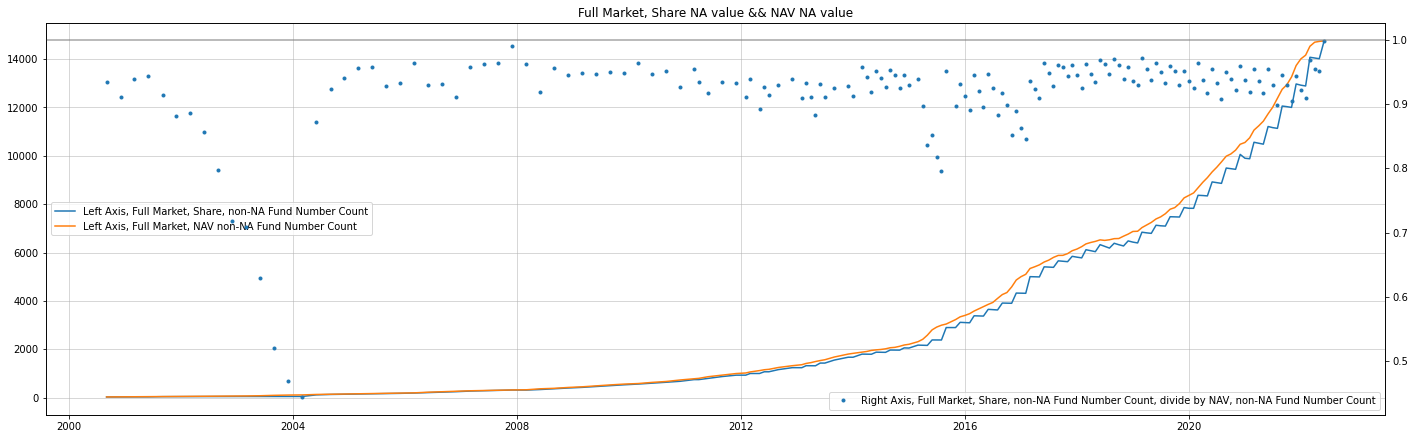

In [99]:
filled_share_info = compare_share_info.fillna(method='ffill')
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='Left Axis, Full Market, Share, non-NA Fund Number Count')
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='Left Axis, Full Market, NAV non-NA Fund Number Count')
ax1.legend(loc='center left')
ax1.grid(linewidth=.5)

ax2 = ax1.twinx()

pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index.astype(np.datetime64)).plot(style='.', label='Right Axis, Full Market, Share, non-NA Fund Number Count, divide by NAV, non-NA Fund Number Count')
plt.title('Full Market, Share NA value && NAV NA value')
ax2.legend(loc='lower right')

ax2.axhline(y=1, color='grey', alpha=.7)


Size effect in fund?

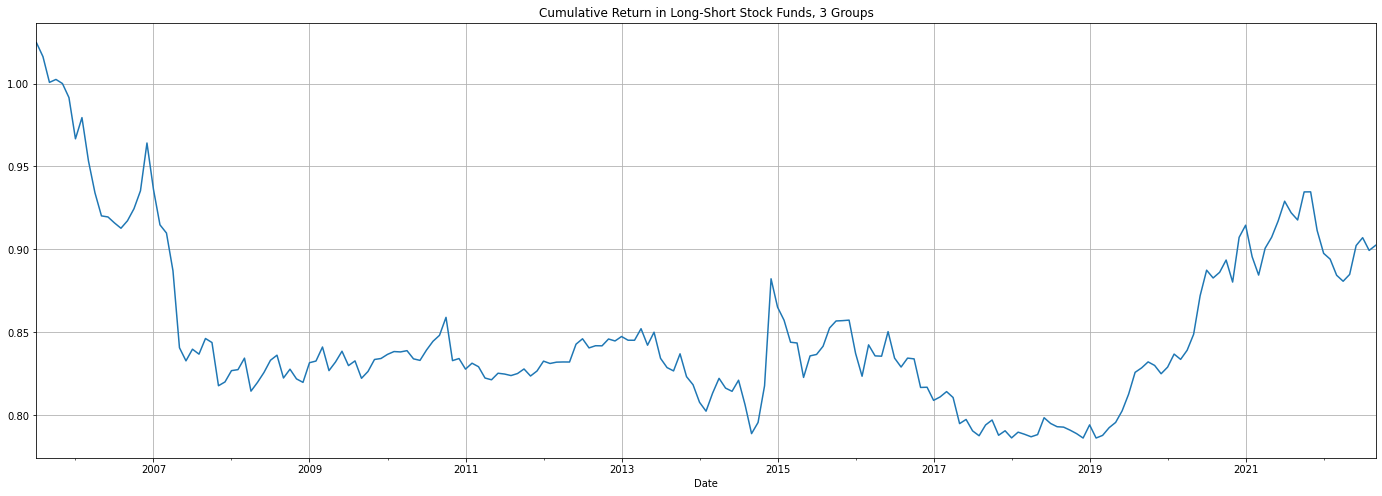

In [100]:
stock_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_csmar_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1).dropna()
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Stock Funds, {groups} Groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [101]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.44259148030520024, pvalue=0.6707371942071949)

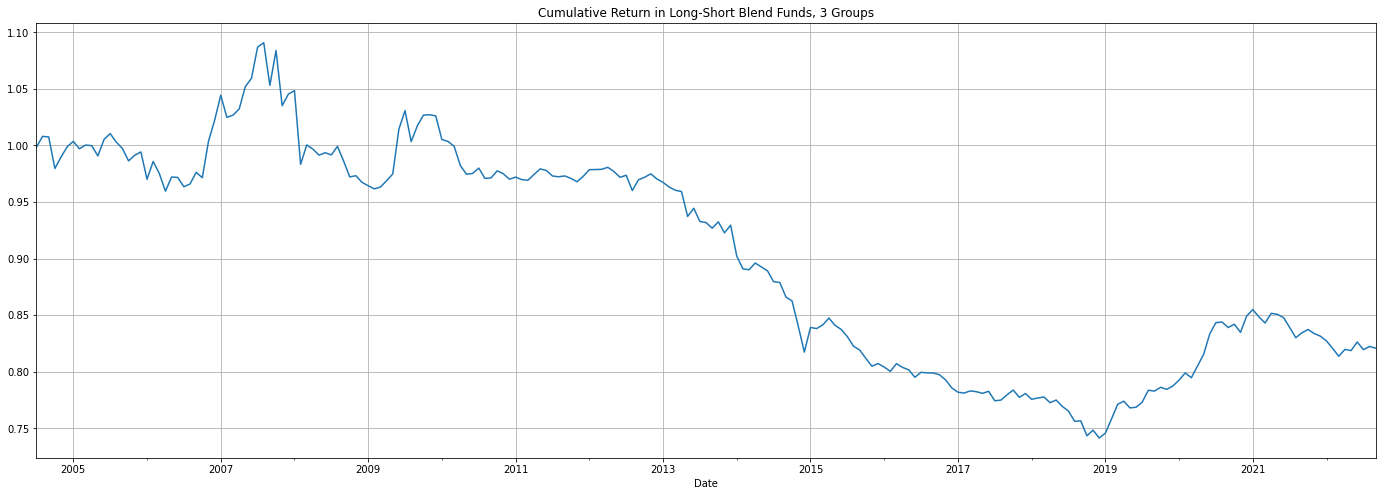

In [102]:
blend_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight_ = pd.concat([blend_fund_weight_, \
    pd.DataFrame([[np.nan] * blend_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight_.columns)])
blend_fund_weight_ = blend_fund_weight_.resample('M').ffill()

groups = 3
ret_blend_fund = return_of_csmar_blend_fund.unstack(0) - 1
blend_fund_groups = blend_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(blend_fund_groups.index, ret_blend_fund.index)
co_stocks = np.intersect1d(blend_fund_groups.columns, ret_blend_fund.columns)

blend_fund_groups = blend_fund_groups.loc[co_time, co_stocks]
ret_blend_fund = ret_blend_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, blend_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Blend Funds, {groups} Groups')
blend_grouped_return = ret_blend_fund.apply(func, axis=1).dropna()

(blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [103]:
stats.ttest_1samp((blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.0540555492750954, pvalue=0.8534878398449912)

### Regression

In [9]:
import pandas as pd
import statsmodels.api as sm
from utils.functions import *

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund

regression table construction

In [10]:
stock_fund_regression = (return_of_csmar_stock_fund.unstack(level=0) * csmar_stock_fund_weight_yearly).sum(axis=1).sort_index()
stock_fund_regression.name = 'stock_fund'

blend_fund_regression = (return_of_csmar_blend_fund.unstack(level=0) * csmar_blend_fund_weight_yearly).sum(axis=1).sort_index()
blend_fund_regression.name = 'blend_fund'


regression_source = pd.merge(stock_fund_regression, svc_source[['mktrf', 'rf', 'smb', 'vmg']], on='Date')
regression_source = pd.merge(regression_source, blend_fund_regression, on='Date')

regression_source['α'] = 1

regression_source = regression_source.loc['2005-6':]
regression_source

,stock_fund,mktrf,rf,smb,vmg,blend_fund,α
Date,,,,,,,
2005-06,0.006722,0.011522,0.001856,0.000517,0.056121,0.006373,1
2005-07,0.004098,-0.019041,0.001856,-0.051082,0.071114,0.004433,1
2005-08,0.030586,0.071589,0.001856,0.094712,-0.049516,0.021039,1
2005-09,-0.016050,0.001288,0.001856,0.033242,0.045120,0.001628,1
2005-10,-0.034043,-0.054595,0.001856,-0.001480,0.024557,-0.023213,1
...,...,...,...,...,...,...,...
2022-05,0.045640,0.052554,0.001241,0.064625,-0.012790,0.038068,1
2022-06,0.101617,0.088114,0.001241,-0.020506,-0.028009,0.086277,1
2022-07,-0.042162,-0.030989,0.001241,0.071198,-0.005291,-0.031624,1


naïve regression

In [11]:
stock_naïve = sm.OLS(regression_source.stock_fund, regression_source[['α']]).fit()
blend_naïve = sm.OLS(regression_source.blend_fund, regression_source[['α']]).fit()
stock_naïve_excess = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α']]).fit()
blend_naïve_excess = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α']]).fit()


In [12]:
pd.DataFrame(
[
[float_to_percent(stock_naïve.params[0]), stock_naïve.tvalues.iloc[0].round(3), stock_naïve.pvalues[0].round(3), yearly_return(stock_naïve.params[0])],
[float_to_percent(blend_naïve.params[0]), blend_naïve.tvalues.iloc[0].round(3), blend_naïve.pvalues[0].round(3), yearly_return(blend_naïve.params[0])],
[float_to_percent(stock_naïve_excess.params[0]), stock_naïve_excess.tvalues.iloc[0].round(3), stock_naïve_excess.pvalues[0].round(3), yearly_return(stock_naïve_excess.params[0])],
[float_to_percent(blend_naïve_excess.params[0]), blend_naïve_excess.tvalues.iloc[0].round(3), blend_naïve_excess.pvalues[0].round(3), yearly_return(blend_naïve_excess.params[0])],
],
index=['stock_naïve', 'blend_naïve', 'stock_naïve_excess', 'blend_naïve_excess'], columns=pd.Series(['α', 't', 'p', 'annual α'],\
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}'))

2005/6-2022/9,α,t,p,annual α
stock_naïve,1.138%,2.451,0.015,14.54%
blend_naïve,1.088%,2.964,0.003,13.86%
stock_naïve_excess,0.948%,2.039,0.043,11.98%
blend_naïve_excess,0.897%,2.444,0.015,11.32%


CAPM regression

In [13]:
stock_capm = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()
blend_capm = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()

In [14]:
pd.DataFrame(
[
[float_to_percent(stock_capm.params[0]) + ' (' + str(stock_capm.tvalues.iloc[0].round(3)) + ')', \
    str(stock_capm.params[1].round(3)) + ' (' + str(stock_capm.tvalues.iloc[1].round(3)) + ')',\
         stock_capm.rsquared, yearly_return(stock_capm.params[0])],
[float_to_percent(blend_capm.params[0]) + ' (' + str(blend_capm.tvalues.iloc[0].round(3)) + ')', \
    str(blend_capm.params[1].round(3)) + ' (' + str(blend_capm.tvalues.iloc[1].round(3)) + ')', \
        blend_capm.rsquared, yearly_return(blend_capm.params[0])],
],
columns=['α', 'mktrf', 'r^2', 'annual α'], index=pd.Series(['stock_capm', 'blend_capm'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_capm,blend_capm
α,0.213% (1.37),0.337% (2.199)
mktrf,0.811 (40.777),0.618 (31.555)
r^2,0.889769,0.828582
annual α,2.59%,4.13%


SVC regression

In [15]:
stock_svc = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()
blend_svc = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()

In [16]:
pd.DataFrame(
[
[float_to_percent(stock_svc.params[0]) + ' (' + str(stock_svc.tvalues.iloc[0].round(3)) + ')', \
    str(stock_svc.params[1].round(3)) + ' (' + str(stock_svc.tvalues.iloc[1].round(3)) + ')', \
        str(stock_svc.params[2].round(3)) + ' (' + str(stock_svc.tvalues.iloc[2].round(3)) + ')', \
            str(stock_svc.params[3].round(3)) + ' (' + str(stock_svc.tvalues.iloc[3].round(3)) + ')', \
                stock_svc.rsquared, yearly_return(stock_svc.params[0])],
[float_to_percent(blend_svc.params[0]) + ' (' + str(blend_svc.tvalues.iloc[0].round(3)) + ')', \
    str(blend_svc.params[1].round(3)) + ' (' + str(blend_svc.tvalues.iloc[1].round(3)) + ')', \
        str(blend_svc.params[2].round(3)) + ' (' + str(blend_svc.tvalues.iloc[2].round(3)) + ')', \
            str(blend_svc.params[3].round(3)) + ' (' + str(blend_svc.tvalues.iloc[3].round(3)) + ')', \
                blend_svc.rsquared, yearly_return(blend_svc.params[0])],
],

columns=['α', 'mktrf', 'smb', 'vmg', 'r^2', 'annual α'], index=pd.Series(['stock_svc', 'blend_svc'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/9,stock_svc,blend_svc
α,0.386% (2.407),0.655% (4.133)
mktrf,0.824 (42.918),0.591 (31.199)
smb,-0.183 (-5.28),-0.05 (-1.472)
vmg,-0.024 (-0.531),-0.247 (-5.519)
r^2,0.90528,0.8521
annual α,4.74%,8.15%


## **V. Fund Evaluation**

In [1]:
import datetime
import pandas as pd
import numpy as np
from factors import *
from IPython.display import display
start_time = '2005-6'
end_time = (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')

### CAPM α +

In [2]:
@fund_ended_check
def capm_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit().params[0]
    return α

all_fund_capm_α = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_generation)

all_fund_capm_α.shape

(209, 5286)

In [46]:
group_and_statistic(all_fund_capm_α, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_rolling', time_span = 24)

2005-06/2007-06 2006-06/2008-06 2007-06/2009-06  \
excess α (monthly)         -0.437%         -0.534%          0.054%   
       annual α             -5.12%          -6.22%           0.65%   
       t                     -0.94           -1.19           0.139   
       R^2                     0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.441%          -0.17%          0.104%   
       annual α              5.43%          -2.02%           1.26%   
       t                     0.844          -0.471           0.328   
       R^2                   0.245            0.42           0.363   
       Obs                      25              25              25   
svc α  α (monthly)          0.645%          0.089%          0.266%   
       annual α              8.02%           1.07%           3.23%   
       t                     0.948           0.217           0.833   
       R^2                   0.255           0.476           0.456   
       Obs                      25              25              25   

                   2008-06/2010-06 2009-06/2011-06 2010-06/2012-06  \
excess α (monthly)          0.172%          0.342%          0.215%   
       annual α              2.08%           4.18%           2.61%   
       t                     0.636           0.737           0.467   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.198%          0.344%          0.158%   
       annual α               2.4%           4.21%           1.91%   
       t                     0.769            0.73           0.353   
       R^2                   0.134           0.009           0.098   
       Obs                      25              25              25   
svc α  α (monthly)          0.549%          0.463%          0.393%   
       annual α              6.79%            5.7%           4.82%   
       t                      2.26           0.957           0.965   
       R^2                   0.442           0.306           0.625   
       Obs                      25              25              25   

                   2011-06/2013-06 2012-06/2014-06 2013-06/2015-06  \
excess α (monthly)          0.512%          0.403%          0.396%   
       annual α              6.32%           4.94%           4.86%   
       t                      2.04           1.052             0.5   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.499%          0.403%         -0.062%   
       annual α              6.16%           4.95%          -0.74%   
       t                     1.922           1.031          -0.074   
       R^2                   0.004             0.0           0.087   
       Obs                      25              25              25   
svc α  α (monthly)          0.752%          1.094%          0.271%   
       annual α               9.4%          13.95%            3.3%   
       t                     2.437           3.621           0.533   
       R^2                   0.349            0.65           0.804   
       Obs                      25              25              25   

                   2014-06/2016-06 2015-06/2017-06 2016-06/2018-06  \
excess α (monthly)          0.371%           0.51%          0.839%   
       annual α              4.55%            6.3%          10.54%   
       t                     0.478           1.458           2.426   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.071%          0.604%          0.845%   
       annual α              0.86%           7.49%          10.63%   
       t                     0.095           2.153           2.397   
       R^2                

In [4]:
group_and_statistic(all_fund_capm_α, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.977%  1.076%  1.086%  1.233%  1.248%      0.27%
       annual α     12.38%  13.71%  13.84%  15.84%  16.04%      3.29%
       t             2.005   2.223   2.254   2.515   2.434      1.666
       R^2             0.0    -0.0     0.0     0.0    -0.0       -0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)   0.21%   0.32%  0.341%   0.52%  0.493%     0.283%
       annual α      2.55%   3.91%   4.16%   6.42%   6.08%      3.45%
       t             1.611   2.249   2.194    2.31   2.204       1.73
       R^2            0.93   0.915   0.898   0.793   0.813      0.002
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.373%  0.543%  0.651%  0.802%  0.975%     0.602%
       annual α      4.57%   6.72%    8.1%  10.07%  12.35%      7.47%
       t             2.651   3.558   4.044   3.274   4.301      3.578
       R^2           0.933   0.921   0.911     0.8   0.844      0.142
       Obs             207     207     207     207     207        207

### SVC α +

In [5]:
from factors import *
from IPython.display import display

@fund_ended_check
def svc_α_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit().params[0]
    return α

all_fund_svc_α = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_generation)

all_fund_svc_α.shape

(209, 5286)

In [6]:
group_and_statistic(all_fund_svc_α, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)   0.93%  1.031%  1.128%  1.261%  1.265%     0.334%
       annual α     11.75%   13.1%  14.41%  16.23%  16.28%      4.09%
       t             1.904   2.118   2.365    2.49   2.501      2.112
       R^2             0.0     0.0     0.0     0.0     0.0       -0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.162%  0.268%  0.388%  0.541%  0.517%     0.355%
       annual α      1.96%   3.27%   4.76%   6.69%   6.38%      4.35%
       t             1.223   1.949   2.578   2.152   2.387      2.232
       R^2           0.928   0.921   0.902   0.758    0.82      0.007
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.205%  0.439%  0.675%  0.871%  1.058%     0.854%
       annual α      2.49%    5.4%   8.41%  10.97%  13.47%     10.74%
       t               1.4   2.936   4.258   3.188   4.957       5.91
       R^2           0.928   0.925   0.912   0.768   0.858      0.336
       Obs             207     207     207     207     207        207

In [7]:
group_and_statistic(all_fund_svc_α, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)


2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)          0.027%           0.29%          0.005%   
       annual α              0.33%           3.53%           0.06%   
       t                     0.085           0.889           0.017   
       R^2                    -0.0            -0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.299%          0.227%         -0.076%   
       annual α              3.65%           2.76%          -0.91%   
       t                     0.716           0.758          -0.277   
       R^2                   0.042           0.194           0.102   
       Obs                      26              26              26   
svc α  α (monthly)          1.116%          0.531%         -0.177%   
       annual α             14.25%           6.56%           -2.1%   
       t                     2.523           1.899          -0.513   
       R^2                   0.367           0.437           0.294   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.574%          0.164%          0.651%   
       annual α              7.11%           1.98%            8.1%   
       t                     1.312           0.209           3.354   
       R^2                    -0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.578%          0.205%          0.648%   
       annual α              7.16%           2.48%           8.06%   
       t                     1.303           0.252           3.281   
       R^2                   0.015           0.003           0.007   
       Obs                      26              26              26   
svc α  α (monthly)          1.401%          0.205%          0.444%   
       annual α             18.17%           2.48%           5.46%   
       t                     4.163           0.454           1.958   
       R^2                   0.664           0.843           0.199   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)          0.723%          0.238%  
       annual α              9.03%           2.89%  
       t                     1.949           0.383  
       R^2                     0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          0.635%          0.399%  
       annual α              7.89%           4.89%  
       t                     1.677           0.697  
       R^2                   0.046           0.198  
       Obs                      26              25  
svc α  α (monthly)          0.767%          0.907%  
       annual α               9.6%          11.44%  
       t                     2.527            2.46  
       R^2                   0.463           0.713  
       Obs                      26              25

### CAPM α/ε ?

In [8]:
from factors import *
from IPython.display import display

@fund_ended_check
def capm_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_capm_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_ε_generation)

all_fund_capm_α_ε.shape

(209, 5286)

In [9]:
group_and_statistic(all_fund_capm_α_ε, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.115%  1.119%  1.081%  1.311%  1.263%     0.148%
       annual α     14.23%  14.28%  13.78%  16.92%  16.25%      1.79%
       t             2.201   2.265   2.222   2.459   2.591      1.358
       R^2            -0.0     0.0     0.0    -0.0     0.0        0.0
       Obs             205     205     205     205     205        205
capm α α (monthly)  0.352%  0.384%  0.363%  0.616%   0.55%     0.199%
       annual α       4.3%    4.7%   4.44%   7.65%   6.81%      2.41%
       t             2.165   2.195   1.997   2.002   2.855      1.888
       R^2           0.899   0.877   0.863   0.672   0.846      0.085
       Obs             205     205     205     205     205        205
svc α  α (monthly)  0.661%  0.747%  0.708%  0.789%   0.91%     0.249%
       annual α      8.23%   9.34%   8.84%   9.89%  11.48%      3.03%
       t             3.927   4.179   3.765   2.324   4.589      2.157
       R^2           0.911   0.895    0.88   0.675   0.867      0.105
       Obs             205     205     205     205     205        205

In [10]:
group_and_statistic(all_fund_capm_α_ε, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-08/2007-09 2007-10/2009-11 2009-12/2012-01  \
excess α (monthly)         -0.122%           0.26%          0.041%   
       annual α             -1.46%           3.17%           0.49%   
       t                     -0.29           0.715            0.19   
       R^2                    -0.0            -0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.495%           0.15%         -0.024%   
       annual α               6.1%           1.81%          -0.28%   
       t                     0.928           0.547          -0.113   
       R^2                   0.116            0.46           0.109   
       Obs                      26              26              26   
svc α  α (monthly)          0.734%          0.311%         -0.003%   
       annual α              9.17%           3.79%          -0.04%   
       t                     1.082           1.002          -0.014   
       R^2                   0.164           0.494           0.441   
       Obs                      26              26              26   

                   2012-02/2014-03 2014-04/2016-05 2016-06/2018-06  \
excess α (monthly)          0.295%          0.472%          0.538%   
       annual α              3.59%           5.81%           6.65%   
       t                     1.347           1.421           2.321   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              25   
capm α α (monthly)          0.312%          0.576%          0.539%   
       annual α               3.8%           7.13%           6.66%   
       t                     1.421           1.734            2.27   
       R^2                   0.041           0.083             0.0   
       Obs                      26              26              25   
svc α  α (monthly)          0.605%          0.611%         -0.017%   
       annual α               7.5%           7.58%           -0.2%   
       t                     3.498           1.559          -0.078   
       R^2                   0.652           0.354           0.516   
       Obs                      26              26              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.048%         -0.353%  
       annual α              0.57%          -4.16%  
       t                     0.191          -0.979  
       R^2                    -0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.137%         -0.307%  
       annual α              1.66%          -3.63%  
       t                     0.557          -0.848  
       R^2                   0.111           0.048  
       Obs                      25              25  
svc α  α (monthly)          0.013%         -0.277%  
       annual α              0.16%          -3.28%  
       t                     0.063          -0.712  
       R^2                   0.448           0.053  
       Obs                      25              25

### SVC α/ε +

In [11]:
from factors import *
from IPython.display import display

@fund_ended_check
def svc_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_ε_generation)

all_fund_svc_α_ε.shape

(209, 5286)

In [12]:
group_and_statistic(all_fund_svc_α_ε, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.059%  1.066%  1.102%  1.331%  1.304%     0.245%
       annual α     13.48%  13.57%  14.06%  17.19%  16.82%      2.98%
       t             2.133   2.179     2.2   2.511   2.555      2.033
       R^2             0.0    -0.0     0.0     0.0     0.0       -0.0
       Obs             203     203     203     203     203        203
capm α α (monthly)  0.283%  0.321%  0.335%  0.607%  0.535%     0.252%
       annual α      3.45%   3.92%   4.09%   7.53%   6.61%      3.06%
       t             1.876   1.762   1.862   2.054    2.64      2.074
       R^2           0.909   0.864   0.874   0.695   0.845      0.001
       Obs             203     203     203     203     203        203
svc α  α (monthly)  0.532%  0.634%  0.716%  0.851%  1.034%     0.502%
       annual α      6.57%   7.88%   8.94%   10.7%  13.13%      6.19%
       t             3.333   3.323    3.92   2.632    5.25      4.178
       R^2           0.917   0.878   0.893     0.7    0.88      0.199
       Obs             203     203     203     203     203        203

In [13]:
group_and_statistic(all_fund_svc_α_ε, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-10/2007-11 2007-12/2010-01 2010-02/2012-03  \
excess α (monthly)          0.482%          0.249%          0.003%   
       annual α              5.95%           3.02%           0.04%   
       t                     1.248           0.682           0.015   
       R^2                     0.0             0.0            -0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.364%          0.116%          -0.05%   
       annual α              4.45%            1.4%           -0.6%   
       t                     0.723           0.437          -0.254   
       R^2                   0.006           0.493           0.123   
       Obs                      26              26              26   
svc α  α (monthly)          1.148%          0.274%          0.137%   
       annual α             14.69%           3.34%           1.65%   
       t                     1.813           0.938           0.833   
       R^2                    0.15           0.531           0.666   
       Obs                      26              26              26   

                   2012-04/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)          0.061%          0.361%          0.306%   
       annual α              0.74%           4.42%           3.73%   
       t                      0.16           0.781           2.029   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.098%          0.264%          0.311%   
       annual α              1.18%           3.21%           3.79%   
       t                     0.264           0.557           2.027   
       R^2                     0.1           0.039           0.013   
       Obs                      25              25              25   
svc α  α (monthly)          0.686%         -0.033%          0.307%   
       annual α              8.55%           -0.4%           3.75%   
       t                     2.006          -0.087           1.559   
       R^2                   0.545           0.714           0.016   
       Obs                      25              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.413%          0.083%  
       annual α              5.07%            1.0%  
       t                     2.192           0.179  
       R^2                     0.0            -0.0  
       Obs                      25              25  
capm α α (monthly)          0.492%          0.195%  
       annual α              6.06%           2.36%  
       t                     2.709           0.452  
       R^2                   0.151           0.174  
       Obs                      25              25  
svc α  α (monthly)          0.523%          0.445%  
       annual α              6.46%           5.47%  
       t                     3.294           1.179  
       R^2                   0.426           0.455  
       Obs                      25              25

### IC : Industry Concentration ?

In [14]:
import pandas as pd
import numpy as np
from factors import *
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

auth success 


In [15]:
return_of_all_fund_ = return_of_all_fund.unstack(0).loc[start_time: end_time]

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

month_mkt_value_ = pd.merge(csmar_monthly_stock, jq_stock_classification, on='Stkcd', validate='m:1')
month_mkt_value_ = month_mkt_value_.groupby(['Date', 'Indnme']).apply(lambda x: x.Msmvttl.sum())
month_mkt_value_ = month_mkt_value_.unstack().div(month_mkt_value_.unstack().sum(axis=1), axis=0).fillna(0)


In [16]:
invest_industry_sum = invest_detail_.groupby(['Symbol', 'Date', 'Indnme']).apply(lambda x: x.Proportion.sum())

In [17]:
invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
unstacked = invest_industry_proportion.unstack(level=[0, 2]).T

In [18]:
all_quarters = pd.date_range('2000-1', datetime.datetime.now().strftime('%Y-%m'), freq='q').to_period('M')

In [19]:
invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
unstacked = invest_industry_proportion.unstack(level=[0, 2]).T

In [20]:
unstacked.loc[:, unstacked.columns.isin(all_quarters)] = unstacked.loc[:, unstacked.columns.isin(all_quarters)].fillna(0)

In [21]:
unstacked[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
unstacked = unstacked.T
invest_industry_proportion = unstacked.resample('M').ffill().fillna(method='ffill')
invest_industry_proportion = invest_industry_proportion.stack(0).swaplevel().sort_index().fillna(0)

month_mkt_value_ = pd.merge(invest_industry_proportion.reset_index()[['Symbol', 'Date']], month_mkt_value_, on='Date')\
    .set_index(['Symbol', 'Date']).sort_index()

In [22]:
industry_concentration = ((invest_industry_proportion - month_mkt_value_) ** 2).sum(axis=1)
industry_concentration = industry_concentration.unstack().T.loc[start_time: end_time]

co_funds = np.intersect1d(industry_concentration.columns, return_of_all_fund_.columns)
industry_concentration = industry_concentration[co_funds]

industry_concentration.shape

(209, 939)

In [23]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.107%  1.274%  1.098%  1.079%  0.992%    -0.114%
       annual α     14.12%  16.41%   14.0%  13.74%  12.58%     -1.36%
       t             2.285   2.467   2.281   2.178   1.918     -0.868
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.347%  0.538%  0.357%  0.328%  0.205%    -0.142%
       annual α      4.24%   6.66%   4.36%   4.01%   2.49%     -1.69%
       t             2.569   2.116   2.208   1.764   1.083     -1.073
       R^2           0.924   0.761   0.889   0.861   0.869      0.016
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.503%  0.632%   0.65%  0.691%   0.66%     0.157%
       annual α      6.21%   7.85%   8.08%   8.61%   8.22%       1.9%
       t             3.415   2.242   3.812   3.582   3.463        1.2
       R^2           0.926   0.762     0.9   0.879   0.891      0.211
       Obs             207     207     207     207     207        207

In [24]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)         -0.305%         -0.418%         -0.047%   
       annual α             -3.59%           -4.9%          -0.56%   
       t                    -0.745          -1.171          -0.255   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.072%          -0.35%         -0.086%   
       annual α              0.87%          -4.12%          -1.02%   
       t                     0.137          -1.063          -0.463   
       R^2                   0.051           0.189           0.054   
       Obs                      26              26              26   
svc α  α (monthly)         -0.055%         -0.363%         -0.035%   
       annual α             -0.66%          -4.27%          -0.42%   
       t                    -0.081          -1.017          -0.164   
       R^2                   0.066           0.237           0.374   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.166%         -0.366%         -0.449%   
       annual α               2.0%           -4.3%          -5.26%   
       t                     0.457          -0.803          -1.585   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.173%          -0.51%         -0.456%   
       annual α              2.09%          -5.95%          -5.34%   
       t                     0.486           -1.14          -1.592   
       R^2                   0.079           0.108           0.019   
       Obs                      26              26              26   
svc α  α (monthly)          0.555%         -0.114%          0.349%   
       annual α              6.86%          -1.36%           4.27%   
       t                     2.075          -0.254           2.066   
       R^2                    0.69           0.545           0.791   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)           0.23%          0.288%  
       annual α               2.8%           3.52%  
       t                      0.67           0.557  
       R^2                     0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          0.097%          0.411%  
       annual α              1.17%           5.05%  
       t                     0.289           0.847  
       R^2                   0.123           0.167  
       Obs                      26              25  
svc α  α (monthly)          0.228%           0.69%  
       annual α              2.77%            8.6%  
       t                     0.693           1.551  
       R^2                   0.268           0.399  
       Obs                      26              25

### AS : Active Share ?

In [25]:
import numpy as np

from IPython.display import display
from factors import *
from data.CSMAR.index_weight import *
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

In [26]:
return_of_all_fund_ = return_of_all_fund.unstack(0).loc[start_time: end_time]

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

In [27]:
invest_detail_ = invest_detail_.drop_duplicates(['Symbol', 'Date', 'Stkcd'])
invest_detail_ = invest_detail_[invest_detail_.Date >= start_time]
invest_detail_ = invest_detail_.pivot(index=['Symbol', 'Date'], columns='Stkcd', values='Proportion')
invest_detail_ = invest_detail_.div(invest_detail_.sum(axis=1), axis=0) * 100


In [28]:
hs300_weight_in_csmar_form = pd.DataFrame(columns=csmar_hs300_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_hs300_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

hs300_co_stocks = np.intersect1d(invest_detail_.columns, hs300_weight_in_csmar_form.columns)
hs300_AS = (np.abs(hs300_weight_in_csmar_form[hs300_co_stocks] - invest_detail_[hs300_co_stocks])).sum(axis=1) / 2

sz50_weight_in_csmar_form = pd.DataFrame(columns=csmar_sz50_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_sz50_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

sz50_co_stocks = np.intersect1d(invest_detail_.columns, csmar_sz50_weight.columns)
sz50_AS = (np.abs(sz50_weight_in_csmar_form[sz50_co_stocks] - invest_detail_[sz50_co_stocks])).sum(axis=1) / 2

zz500_weight_in_csmar_form = pd.DataFrame(columns=csmar_zz500_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_zz500_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

zz500_co_stocks = np.intersect1d(invest_detail_.columns, csmar_zz500_weight.columns)
zz500_AS = (np.abs(zz500_weight_in_csmar_form[zz500_co_stocks] - invest_detail_[zz500_co_stocks])).sum(axis=1) / 2

In [29]:
active_share = pd.concat([hs300_AS, zz500_AS, sz50_AS], axis=1).replace(0, np.inf).min(axis=1).unstack(0)
co_funds = np.intersect1d(active_share.columns, return_of_all_fund_.columns)
active_share = active_share[co_funds].replace(np.inf, np.nan).loc[start_time: end_time].dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
active_share = active_share.T
active_share[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
active_share = active_share.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
active_share.shape

(209, 939)

In [30]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.149%  1.035%  1.157%  1.245%  0.992%    -0.158%
       annual α      14.7%  13.15%   14.8%  16.01%  12.57%     -1.87%
       t             2.367   2.135   2.361   2.444   2.022     -1.624
       R^2            -0.0    -0.0    -0.0     0.0     0.0       -0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.404%   0.29%  0.409%  0.524%  0.221%    -0.183%
       annual α      4.96%   3.54%   5.02%   6.47%   2.68%     -2.18%
       t             2.418   1.751    2.33   2.045   1.651     -1.897
       R^2           0.884   0.885   0.874   0.751   0.927      0.026
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.753%  0.631%   0.72%  0.661%  0.475%    -0.279%
       annual α      9.42%   7.84%   8.99%   8.23%   5.85%     -3.29%
       t             4.293     3.7   3.979   2.332   3.347      -2.63
       R^2           0.896   0.901   0.891   0.753   0.933      0.048
       Obs             207     207     207     207     207        207

In [31]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)         -0.458%          -0.36%         -0.062%   
       annual α             -5.36%          -4.24%          -0.74%   
       t                    -1.432          -1.266           -0.25   
       R^2                     0.0            -0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)         -0.624%         -0.299%         -0.002%   
       annual α             -7.24%          -3.53%          -0.03%   
       t                    -1.491          -1.179           -0.01   
       R^2                   0.016           0.242            0.07   
       Obs                      26              26              26   
svc α  α (monthly)          -0.63%         -0.277%          0.241%   
       annual α              -7.3%          -3.27%           2.94%   
       t                    -1.168          -1.051           0.712   
       R^2                   0.041           0.344           0.129   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.057%          0.159%         -0.409%   
       annual α              0.69%           1.93%           -4.8%   
       t                     0.249           0.772          -1.771   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.052%          0.091%         -0.404%   
       annual α              0.63%            1.1%          -4.74%   
       t                     0.234           0.452          -1.726   
       R^2                   0.101           0.118           0.016   
       Obs                      26              26              26   
svc α  α (monthly)          0.024%          0.259%          -0.37%   
       annual α              0.29%           3.15%          -4.35%   
       t                     0.084           1.156          -1.267   
       R^2                   0.104           0.444           0.063   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)         -0.216%          0.036%  
       annual α             -2.56%           0.43%  
       t                    -1.017           0.084  
       R^2                    -0.0             0.0  
       Obs                      26              25  
capm α α (monthly)         -0.151%          0.005%  
       annual α             -1.79%           0.06%  
       t                    -0.707           0.011  
       R^2                   0.077           0.016  
       Obs                      26              25  
svc α  α (monthly)         -0.162%         -0.193%  
       annual α             -1.92%           -2.3%  
       t                    -0.712          -0.529  
       R^2                   0.082           0.388  
       Obs                      26              25

### Connected Companies Portfolio CAPM +

In [38]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [39]:
invest_detail.loc[:, 'Symbol'] = invest_detail.Symbol.str.zfill(6)
invest_detail = invest_detail[invest_detail.Date.between(start_time, end_time)]
v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))



In [40]:
@fund_ended_check
def capm_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_capm_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(capm_α_ε_generation)

In [41]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_capm_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_capm_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
ccp_capm_it = ccp_capm_it.T
ccp_capm_it[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
ccp_capm_it = ccp_capm_it.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
ccp_capm_it.shape

(209, 3376)

In [42]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.814%  1.169%  1.023%  1.136%  1.269%     0.455%
       annual α     10.22%  14.97%   13.0%  14.51%  16.34%      5.59%
       t             1.969   2.343   2.073   2.204   2.391      2.128
       R^2             0.0    -0.0    -0.0    -0.0     0.0       -0.0
       Obs             204     204     204     204     204        204
capm α α (monthly)  0.184%  0.464%  0.285%  0.368%  0.488%     0.304%
       annual α      2.23%   5.71%   3.48%    4.5%   6.01%       3.7%
       t             1.568   2.021   1.697   2.051   2.427      1.574
       R^2           0.921   0.792   0.886   0.881   0.859      0.198
       Obs             204     204     204     204     204        204
svc α  α (monthly)  0.269%  0.588%  0.619%  0.714%   0.86%     0.591%
       annual α      3.28%   7.28%   7.68%   8.91%  10.83%      7.33%
       t             2.092   2.326   3.569   3.859   4.127       2.89
       R^2           0.922   0.794   0.901   0.896   0.876      0.262
       Obs             204     204     204     204     204        204

In [43]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-09/2007-10 2007-11/2009-12 2010-01/2012-02  \
excess α (monthly)          1.058%          0.148%          0.017%   
       annual α             13.47%            1.8%            0.2%   
       t                     2.457           0.367           0.048   
       R^2                    -0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.291%          0.232%          0.085%   
       annual α              3.55%           2.82%           1.03%   
       t                      0.63            0.69           0.239   
       R^2                    0.26            0.34            0.05   
       Obs                      26              26              26   
svc α  α (monthly)         -0.079%          0.381%         -0.072%   
       annual α             -0.94%           4.67%          -0.86%   
       t                    -0.128             1.0          -0.158   
       R^2                   0.289           0.368           0.146   
       Obs                      26              26              26   

                   2012-03/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)          0.461%          0.291%           0.56%   
       annual α              5.68%           3.54%           6.93%   
       t                     1.071           0.247           1.242   
       R^2                     0.0             0.0             0.0   
       Obs                      26              25              25   
capm α α (monthly)          0.465%         -0.517%          0.586%   
       annual α              5.72%          -6.04%           7.27%   
       t                     1.059          -0.551           1.302   
       R^2                   0.005           0.417           0.048   
       Obs                      26              25              25   
svc α  α (monthly)          1.247%         -0.811%         -0.127%   
       annual α             16.03%          -9.31%          -1.51%   
       t                     2.916          -1.078          -0.279   
       R^2                   0.437           0.829           0.416   
       Obs                      26              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.935%          0.171%  
       annual α             11.82%           2.08%  
       t                     2.068           0.222  
       R^2                     0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.691%          0.409%  
       annual α              8.62%           5.02%  
       t                      1.69           0.605  
       R^2                   0.252           0.279  
       Obs                      25              25  
svc α  α (monthly)          0.514%          0.898%  
       annual α              6.35%          11.32%  
       t                      1.43           1.654  
       R^2                   0.489             0.6  
       Obs                      25              25

### Connected Companies Portfolio SVC ?

In [32]:
import numpy as np
import pandas as pd
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [33]:
invest_detail.loc[:, 'Symbol'] = invest_detail.Symbol.str.zfill(6)
invest_detail = invest_detail[invest_detail.Date.between(start_time, end_time)]

v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))

In [34]:
from factors import *
from IPython.display import display
@fund_ended_check
def svc_α_ε_generation(x):
    x = x.dropna()  
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = sm.OLS(x - temp_regression.rf, temp_regression[['α', 'mktrf', 'smb', 'vmg']]).fit()
    α = result.params[0]
    ε = result.resid.std()
    division = α / ε
    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).apply(svc_α_ε_generation)

In [35]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_svc_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_svc_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())

ccp_svc_it = ccp_svc_it.T
ccp_svc_it[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
ccp_svc_it = ccp_svc_it.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
ccp_svc_it.shape

(209, 3376)

In [36]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.968%  1.127%   1.06%  1.112%  1.157%      0.19%
       annual α     12.25%  14.39%  13.49%  14.19%  14.81%       2.3%
       t             2.262   2.298   2.122   2.139   2.167      0.851
       R^2             0.0    -0.0    -0.0    -0.0    -0.0        0.0
       Obs             201     201     201     201     201        201
capm α α (monthly)  0.315%  0.409%  0.305%  0.334%  0.363%     0.049%
       annual α      3.84%   5.01%   3.72%   4.08%   4.45%      0.59%
       t             2.388   2.032    1.82    1.78   1.803      0.236
       R^2           0.907   0.835   0.889   0.872    0.86      0.155
       Obs             201     201     201     201     201        201
svc α  α (monthly)  0.309%  0.534%  0.609%  0.689%  0.831%     0.522%
       annual α      3.77%   6.61%   7.56%   8.59%  10.44%      6.44%
       t             2.134   2.426    3.49   3.571   4.121      2.483
       R^2           0.908   0.837   0.901   0.889   0.885      0.283
       Obs             201     201     201     201     201        201

In [37]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2005-12/2008-01 2008-02/2010-02 2010-03/2012-03  \
excess α (monthly)          0.504%           0.02%          0.362%   
       annual α              6.21%           0.24%           4.43%   
       t                     1.017           0.044            0.88   
       R^2                     0.0             0.0            -0.0   
       Obs                      26              25              25   
capm α α (monthly)         -0.084%          0.076%           0.41%   
       annual α              -1.0%           0.92%           5.03%   
       t                     -0.15           0.187           0.973   
       R^2                   0.134           0.202           0.021   
       Obs                      26              25              25   
svc α  α (monthly)          0.764%            0.2%          0.403%   
       annual α              9.56%           2.43%           4.94%   
       t                     1.089           0.444           0.724   
       R^2                   0.306           0.225            0.03   
       Obs                      26              25              25   

                   2012-04/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)          0.227%         -0.785%          0.402%   
       annual α              2.75%          -9.03%           4.93%   
       t                     0.418           -0.67           1.302   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)           0.26%         -1.518%           0.41%   
       annual α              3.16%         -16.77%           5.03%   
       t                     0.478          -1.533           1.304   
       R^2                    0.04           0.346           0.009   
       Obs                      25              25              25   
svc α  α (monthly)          1.308%         -1.987%          0.049%   
       annual α             16.88%         -21.41%           0.59%   
       t                      2.49          -2.706           0.137   
       R^2                   0.466           0.835           0.208   
       Obs                      25              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.758%          0.018%  
       annual α              9.49%           0.22%  
       t                     1.585           0.023  
       R^2                    -0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.439%          0.307%  
       annual α               5.4%           3.75%  
       t                      1.12           0.475  
       R^2                   0.385           0.384  
       Obs                      25              25  
svc α  α (monthly)          0.411%          0.884%  
       annual α              5.04%          11.14%  
       t                     1.001           2.375  
       R^2                   0.406           0.825  
       Obs                      25              25

### RG : Return Gap ?

In [49]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.CSMAR.fees import csmar_fees
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds
from data.TwoStepData.return_of_all_fund import return_of_all_fund

In [50]:
fees = csmar_fees.groupby(['Symbol', 'Date']).apply(lambda x: x.ProportionOfFee.sum()).reset_index().rename(columns={0: 'fees'})
fees['Symbol'] = fees.reset_index().Symbol.str.zfill(6)
fees = fees.set_index(['Date', 'Symbol'])
co_index = np.intersect1d(filtered_funds.stack()[filtered_funds.stack()].index, fees.index)
fees = fees.loc[co_index]
return_gap = pd.merge(invest_detail, fees, on=['Date', 'Symbol'], how='left').fillna(0)
return_gap['fees'] = return_gap.fees.fillna(0)
return_gap = pd.merge(return_gap, csmar_monthly_stock, on=['Date', 'Stkcd'])
return_gap = pd.merge(return_gap, return_of_all_fund.reset_index(), on=['Date', 'Symbol'])

return_gap['Proportion'] = return_gap[['Date', 'Symbol', 'Proportion']].groupby(['Date', 'Symbol']).apply(lambda x: x.Proportion / x.Proportion.sum()).values
rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum() - x.fees.iloc[0] / 100)
# rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum())

In [51]:
rf_return_of_fund = return_gap.groupby(['Date', 'Symbol']).last().return_of_all_fund
rg_t = (rf_return_of_fund - rh_minus_exp_t).unstack().resample('M').ffill().dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
to_be_filled = rg_t.T
to_be_filled[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
rg_t = to_be_filled.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
rg_ret_t = rg_t.rolling(36, min_periods = 24).mean().dropna(how='all', axis=1).loc[start_time: end_time]

In [52]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1, kind='cross_section')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.736%  0.896%  0.892%  0.879%  1.046%     0.311%
       annual α      9.19%  11.29%  11.25%  11.07%  13.31%       3.8%
       t             1.513   1.776   1.822   1.753   2.033      1.992
       R^2             0.0     0.0     0.0     0.0    -0.0        0.0
       Obs             193     193     193     193     193        193
capm α α (monthly)  0.161%  0.296%  0.307%  0.272%  0.421%      0.26%
       annual α      1.95%   3.62%   3.75%   3.32%   5.17%      3.17%
       t             0.885   1.625     1.8   1.734   2.722      1.713
       R^2           0.862   0.871    0.88   0.903   0.911      0.065
       Obs             193     193     193     193     193        193
svc α  α (monthly)  0.586%  0.696%   0.69%  0.567%  0.586%      -0.0%
       annual α      7.27%   8.68%    8.6%   7.01%   7.26%      -0.0%
       t             3.335   3.921   4.076   3.497   3.513     -0.002
       R^2           0.893   0.899   0.902   0.915   0.914      0.199
       Obs             193     193     193     193     193        193

In [53]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1, kind='time_series', time_span=24)

2006-08/2008-08 2008-09/2010-08 2010-09/2012-08  \
excess α (monthly)          1.448%          0.163%          0.109%   
       annual α             18.83%           1.98%           1.31%   
       t                     1.711           0.575           0.449   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              24              24   
capm α α (monthly)          1.113%          0.119%          0.145%   
       annual α             14.21%           1.43%           1.76%   
       t                     1.391           0.416           0.582   
       R^2                   0.174           0.053           0.023   
       Obs                      25              24              24   
svc α  α (monthly)          0.597%         -0.224%         -0.187%   
       annual α               7.4%          -2.65%          -2.22%   
       t                     0.716          -0.656          -0.698   
       R^2                     0.3           0.195           0.545   
       Obs                      25              24              24   

                   2012-09/2014-08 2014-09/2016-08 2016-09/2018-08  \
excess α (monthly)         -0.093%          0.454%          0.299%   
       annual α             -1.11%           5.59%           3.65%   
       t                    -0.309           1.067            2.27   
       R^2                     0.0            -0.0             0.0   
       Obs                      24              24              24   
capm α α (monthly)          -0.12%          0.446%          0.337%   
       annual α             -1.43%           5.49%           4.12%   
       t                    -0.388           1.013           2.845   
       R^2                   0.014           0.001           0.238   
       Obs                      24              24              24   
svc α  α (monthly)         -0.175%           0.29%          0.289%   
       annual α             -2.08%           3.53%           3.52%   
       t                    -0.601           0.849           1.918   
       R^2                   0.574           0.762           0.251   
       Obs                      24              24              24   

                   2018-09/2020-08 2020-09/2022-08  
excess α (monthly)         -0.017%          0.077%  
       annual α              -0.2%           0.93%  
       t                     -0.05           0.159  
       R^2                     0.0             0.0  
       Obs                      24              24  
capm α α (monthly)         -0.064%          0.111%  
       annual α             -0.76%           1.34%  
       t                    -0.182           0.229  
       R^2                   0.019           0.043  
       Obs                      24              24  
svc α  α (monthly)         -0.068%          0.135%  
       annual α             -0.82%           1.63%  
       t                    -0.266           0.315  
       R^2                   0.532           0.368  
       Obs                      24              24


from data.TwoStepData.regression_source import regression_source

def wrapper_rolling_SVC(fund):
    def inner_rolling_SVC(return_data):
        co_time = np.intersect1d(return_data.index, regression_source.index)
        # rg_t - r_f = α + β*mktrf + ...
        result = sm.OLS(return_data.loc[co_time] - regression_source.loc[co_time, 'rf'], regression_source.loc[co_time, ['α', 'mktrf', 'smb', 'vmg']]).fit()
        return result.params[0]
    return fund.rolling(36).apply(inner_rolling_SVC)

rg_α_t = rg_t.apply(wrapper_rolling_SVC).dropna(how='all', axis=1).loc[start_time: end_time]

group_and_statistic(rg_α_t, groups=5, weighting='mkt', interval=1)

## VI. Performance Indicator

In [1]:
from scipy.stats import zscore
from functools import reduce

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from IPython.display import display

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund
from data.TwoStepData.regression_source import regression_source
from utils.functions import *

In [55]:
all_factors = [

all_fund_capm_α,
all_fund_svc_α,
# all_fund_capm_α_ε,
all_fund_svc_α_ε,
# industry_concentration,
# active_share,
ccp_capm_it,
# ccp_svc_it,
# rg_ret_t,

]


In [71]:
truncate_proportion = .01

concatenated_all_factors = pd.concat(all_factors)

concatenated_all_factors = concatenated_all_factors.apply(lambda x: \
    x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(truncate_proportion), x.dropna() < x.dropna().quantile(1 - truncate_proportion))], \
        axis=1)
ivol_condition = return_of_all_fund_.rolling(12).std()
ivol_condition = pd.notna(ivol_condition.apply(lambda x: x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(.2), x.dropna() < x.dropna().quantile(.8))], axis=1))
ivol_condition = ivol_condition.stack()[ivol_condition.stack()].index

mkt_value_condition = pd.notna(all_fund_weight.apply(lambda x: x.dropna()[x.dropna() > x.dropna().quantile(.2)], axis=1))
mkt_value_condition = mkt_value_condition.stack()[mkt_value_condition.stack()].index

filtered_funds_condition = filtered_funds.stack()[filtered_funds.stack()].index

MIN_VALID_NUM = 15
z_scored_all_factors = concatenated_all_factors.apply(lambda x: zscore(x.dropna())\
         if pd.notna(x).sum() >= MIN_VALID_NUM else pd.Series([np.nan] * len(x), index=x.index), axis=1)

return_condition = pd.notna(return_of_all_fund_.shift(-1).apply(lambda x: x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(.01), x.dropna() < x.dropna().quantile(.99))], axis=1))
return_condition = return_condition.stack()[return_condition.stack()].index

filtered_index = reduce(lambda x, y: np.intersect1d(x, y), \
    [ivol_condition, mkt_value_condition, filtered_funds_condition, return_condition, z_scored_all_factors.stack().index])

z_scored_all_factors = z_scored_all_factors.stack().loc[filtered_index].groupby(level=[0,1]).mean().unstack()

In [72]:
def select_funds(top_num : int):
    return z_scored_all_factors.apply(lambda x: x.nlargest(top_num).index, axis=1)

def get_selected_fund_return(date_funds, weighting='1/n'):
    
    date = date_funds.name
    funds = date_funds.values[0]

    if weighting == '1/n':
        return return_of_all_fund_.shift(-1).loc[date, funds].mean()

    elif weighting == 'mkt':
        weights = all_fund_weight.loc[date, funds]
        weights /= weights.sum()

        return (return_of_all_fund_.shift(-1).loc[date, funds] * weights).sum()


selected_funds = select_funds(10)
funds_return = pd.DataFrame(selected_funds).apply(lambda x: get_selected_fund_return(x, 'mkt'), axis=1)
funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)

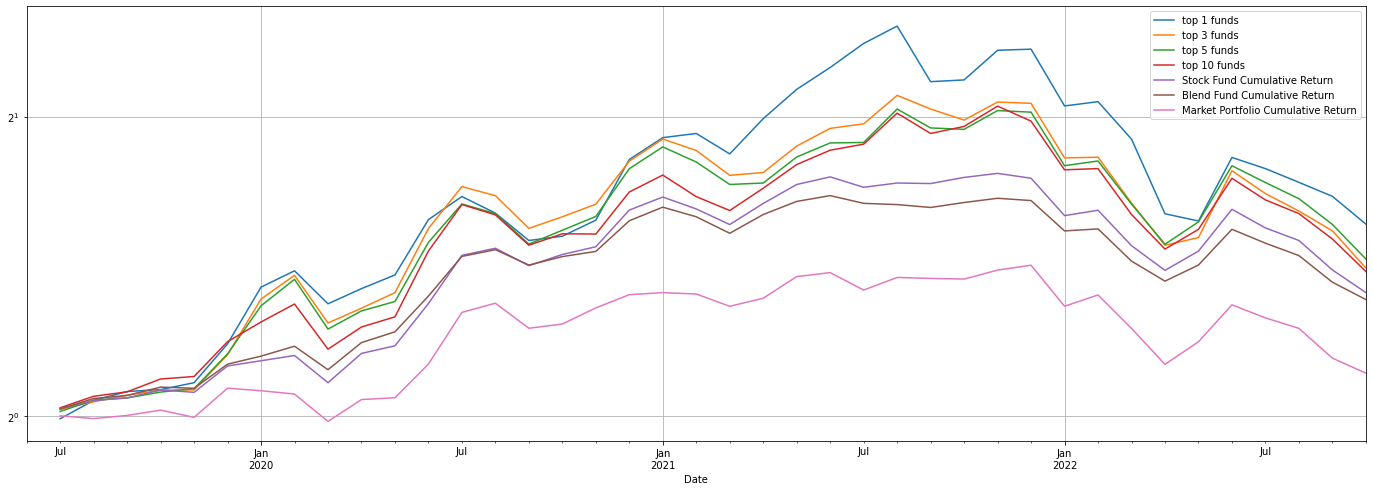

In [73]:

for top_num in [1, 3 ,5 ,10]:
    selected_funds = select_funds(top_num)
    funds_return = pd.DataFrame(selected_funds).apply(lambda x: get_selected_fund_return(x, 'mkt'), axis=1)
    funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)

    plt.yscale('log', base=2)
    (funds_return + 1).cumprod().plot(figsize=(24, 8), label=f'top {top_num} funds')

plot_start_time = funds_return.index[0]
plot_end_time = datetime.datetime.now().strftime('%Y-%m')

((return_of_csmar_stock_fund.unstack().T.dropna(how='all').sort_index() * csmar_stock_fund_weight_yearly.sort_index()).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='Stock Fund Cumulative Return')
((return_of_csmar_blend_fund.unstack().T.dropna(how='all').sort_index() * csmar_blend_fund_weight_yearly.sort_index()).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc[start_time: ].mktrf + svc_source.loc[plot_start_time: ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.grid()
plt.legend()
